In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # Utile pour évaluer le clustering
import joblib # Pour sauvegarder le modèle

# --- Définir le répertoire de travail ---
import os
# Remplacez par le chemin ABSOLU de la racine de votre projet
# ASSUREZ-VOUS QUE CE CHEMIN EST EXACTEMENT LE BON POUR VOTRE MACHINE
project_root_path = 'C:\\Users\\marjane\\OneDrive\\Bureau\\COURSES\\Projet_PFA\\fraud_detection_app'

# Changer le répertoire de travail si nécessaire
if os.getcwd() != project_root_path:
    try:
        os.chdir(project_root_path)
        # Afficher le répertoire de travail actuel comme dernière ligne de la cellule pour confirmation
        os.getcwd()
    except FileNotFoundError:
        "Erreur : Le chemin spécifié n'a pas été trouvé. Vérifiez le chemin absolu de votre projet."
    except Exception as e:
        f"Une erreur est survenue lors du changement de répertoire : {e}"
else:
    # Afficher le répertoire de travail actuel comme dernière ligne de la cellule
    os.getcwd()

# Optionnel : définir le style des graphiques
sns.set_style('whitegrid')


In [35]:
# Chargement des Datasets Prétraités

# Chemin vers le fichier prétraité standardisé
processed_scaled_file_path = 'data/bank_transactions_processed_scaled.csv' # Utilisez le nom que vous avez choisi

# Chemin vers le fichier des features AVANT standardisation (celui que nous venons d'ajouter)
processed_raw_features_file_path = 'data/bank_transactions_features_raw.csv' # Utilisez le nom que vous avez choisi

# Charger le dataset standardisé (pour l'entraînement du modèle)
X_scaled_df = pd.read_csv(processed_scaled_file_path)

# --- AJOUTEZ CETTE LIGNE POUR CHARGER X ---
# Charger le dataset avec les features AVANT standardisation (pour l'analyse des clusters)
X = pd.read_csv(processed_raw_features_file_path)
# ---------------------------------------

# Afficher les premières lignes des deux DataFrames pour vérifier le chargement
X_scaled_df.head()
# X.head() # Vérifiez aussi X
# X_scaled_df.info() # Vérifier les types de données, non-nulls, etc.
# X.info() # Vérifier X

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,TransactionAmount_log,AccountBalance_log,Hour,DayOfWeek,TimeSinceLastTransaction_s,TransactionType_Credit,TransactionType_Debit,Channel_ATM,Channel_Branch,Channel_Online,CustomerOccupation_Doctor,CustomerOccupation_Engineer,CustomerOccupation_Retired,CustomerOccupation_Student
0,-0.855820,-1.105984,-1.181466,-0.206794,-0.888266,-1.031250,-0.628858,0.511423,1.688773,-0.267208,-0.540538,0.540538,1.419720,-0.726623,-0.690491,-0.579189,-0.575512,-0.559572,1.680309
1,-0.289919,0.805347,0.834265,-0.206794,-0.239452,0.181654,0.217929,-0.856729,-0.296655,0.180812,1.850010,-1.850010,-0.704364,-0.726623,1.448244,-0.579189,-0.575512,-0.559572,1.680309
2,0.614606,-1.218415,0.962929,-0.206794,-1.015296,0.841107,-0.953989,-0.856729,-0.296655,-0.267208,-0.540538,0.540538,-0.704364,-0.726623,1.448244,-0.579189,-0.575512,-0.559572,1.680309
3,-0.816319,1.479934,-1.167170,-0.206794,0.163220,-0.857198,0.508493,-0.856729,-0.296655,-0.053399,-0.540538,0.540538,1.419720,-0.726623,-0.690491,-0.579189,-0.575512,-0.559572,1.680309
4,-0.976312,-0.656259,-0.838362,-0.206794,0.334900,-2.078153,0.608833,-0.856729,1.688773,0.308926,-0.540538,0.540538,1.419720,-0.726623,-0.690491,-0.579189,-0.575512,-0.559572,1.680309


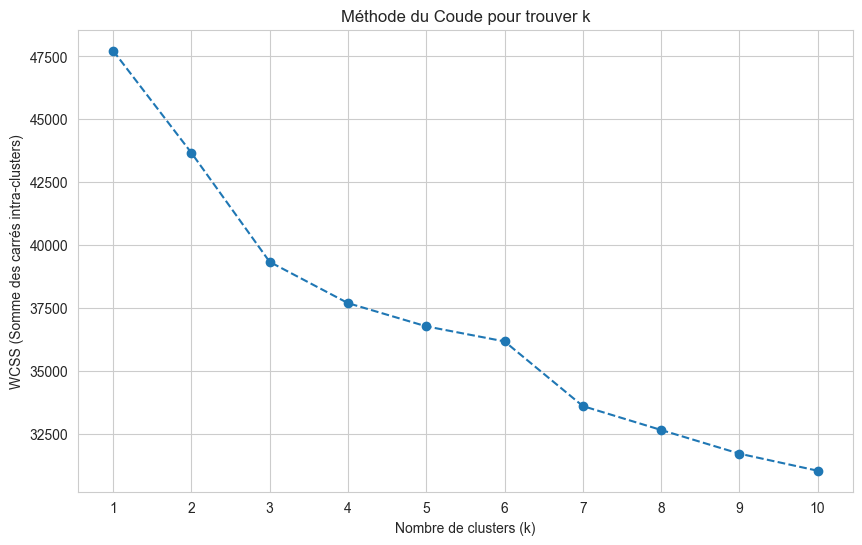

In [36]:
# Calculer la WCSS pour différentes valeurs de k
wcss = []
k_range = range(1, 11) # Tester de 1 à 10 clusters

for k in k_range:
    # Initialiser et entraîner le modèle K-means
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_scaled_df)

    # Ajouter la WCSS (kmeans.inertia_)
    wcss.append(kmeans.inertia_)

# Tracer le graphique de la Méthode du Coude
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Méthode du Coude pour trouver k')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS (Somme des carrés intra-clusters)')
plt.xticks(k_range)
plt.grid(True)
plt.show() # Affichez le graphique

In [37]:
# Choisissez la valeur de k basée sur l'analyse de la Méthode du Coude
optimal_k = 3

# Initialiser le modèle K-means avec le k optimal
kmeans_model = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42)

# Entraîner le modèle sur le dataset standardisé
kmeans_model.fit(X_scaled_df)

# Obtenir les labels de cluster pour chaque transaction
cluster_labels = kmeans_model.labels_

# Afficher les premiers labels et la répartition par cluster
# cluster_labels[:10] # Affiche les 10 premiers labels
pd.Series(cluster_labels).value_counts() # Affiche le nombre de transactions dans chaque cluster

2    1222
1     722
0     568
Name: count, dtype: int64

In [38]:
# S'assurer que le DataFrame X (avant scaling) est disponible.
    # Si vous avez suivi le guide de prétraitement, X devrait être défini juste avant de créer X_scaled_df.
    # Si X n'est pas en mémoire, vous devrez le recréer ou le charger si vous l'aviez sauvegardé.

    # Créer une copie de X pour ajouter les labels sans modifier X original
X_with_labels = X.copy()

    # Ajouter la colonne 'Cluster' avec les labels attribués par K-means
    # IMPORTANT: L'ordre des lignes entre X et cluster_labels DOIT CORRESPONDRE
X_with_labels['Cluster'] = cluster_labels

    # Afficher les premières lignes du DataFrame avec les labels ajoutés
    # X_with_labels.head()

    # Afficher la répartition des transactions par cluster (devrait correspondre à la Cellule 4)
    # X_with_labels['Cluster'].value_counts()

    # Afficher les noms des colonnes pour référence
X_with_labels.columns.tolist()

['TransactionAmount',
 'CustomerAge',
 'TransactionDuration',
 'LoginAttempts',
 'AccountBalance',
 'TransactionAmount_log',
 'AccountBalance_log',
 'Hour',
 'DayOfWeek',
 'TimeSinceLastTransaction_s',
 'TransactionType_Credit',
 'TransactionType_Debit',
 'Channel_ATM',
 'Channel_Branch',
 'Channel_Online',
 'CustomerOccupation_Doctor',
 'CustomerOccupation_Engineer',
 'CustomerOccupation_Retired',
 'CustomerOccupation_Student',
 'Cluster']

In [39]:

# Grouper le DataFrame par le numéro de cluster et calculer la moyenne de chaque feature
cluster_analysis = X_with_labels.groupby('Cluster').mean()

# Affichez l'analyse des centroïdes (moyenne des features par cluster)
cluster_analysis

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,TransactionAmount_log,AccountBalance_log,Hour,DayOfWeek,TimeSinceLastTransaction_s,TransactionType_Credit,TransactionType_Debit,Channel_ATM,Channel_Branch,Channel_Online,CustomerOccupation_Doctor,CustomerOccupation_Engineer,CustomerOccupation_Retired,CustomerOccupation_Student
Cluster,,,,,,,,,,,,,,,,,,,
0,277.813063,45.077465,116.751761,1.100352,5214.432447,5.080443,8.141548,16.642606,1.466549,4.439936e+06,1.0,0.0,0.128521,0.441901,0.429577,0.246479,0.244718,0.264085,0.244718
1,323.444307,31.707756,121.004155,1.123269,1235.293864,5.240428,6.874536,16.627424,1.337950,4.179605e+06,0.0,1.0,0.396122,0.325485,0.278393,0.228532,0.252078,0.214681,0.304709
2,291.514697,52.147300,120.183306,1.136661,7359.614771,5.117459,8.803159,16.617840,1.504910,4.618389e+06,0.0,1.0,0.387889,0.312602,0.299509,0.266776,0.248773,0.240589,0.243863


In [40]:
# Basé sur votre analyse du tableau 'cluster_analysis' (Cellule 6),
# listez l'ID ou les IDs du/des cluster(s) que vous identifiez comme anormaux.
# REMPLACEZ LA LISTE CI-DESSOUS AVEC VOTRE CHOIX (Cluster 0 et Cluster 1) :
anomaly_cluster_ids = [0, 1] # <--- REMPLACEZ LES ID(s) SI VOTRE ANALYSE VOUS CONDUIT À UN AUTRE CHOIX

# Afficher la liste des IDs de clusters considérés comme anormaux
f"ID(s) de cluster(s) identifié(s) comme potentiellement anormaux : {anomaly_cluster_ids}"

'ID(s) de cluster(s) identifié(s) comme potentiellement anormaux : [0, 1]'

In [41]:
# Assurez-vous que le DataFrame X_with_labels (avec les features et la colonne 'Cluster')
# et la liste anomaly_cluster_ids sont disponibles dans la mémoire.

# Ajouter une colonne booléenne 'IsAnomaly' au DataFrame X_with_labels.
# La valeur est True si le numéro de cluster de la transaction est présent dans notre liste d'IDs anormaux.
# La méthode .isin() est efficace pour vérifier si chaque élément d'une colonne est dans une liste.
X_with_labels['IsAnomaly'] = X_with_labels['Cluster'].isin(anomaly_cluster_ids)

# Afficher le nombre total de transactions qui ont été marquées comme anomalies.
# Cela devrait être la somme des transactions dans le Cluster 0 et le Cluster 1 (568 + 722 = 1290).
f"Nombre total de transactions marquées comme anomalies : {X_with_labels['IsAnomaly'].sum()}"

# Optionnel : Affichez les premières lignes du DataFrame pour voir la nouvelle colonne 'IsAnomaly'
# X_with_labels.head()

# Optionnel : Affichez les premières transactions qui sont marquées comme anomalies
# X_with_labels[X_with_labels['IsAnomaly']].head()

'Nombre total de transactions marquées comme anomalies : 1290'

In [42]:
#- Évaluation du Clustering: Silhouette Score) ---

# Assurez-vous que X_scaled_df (vos données standardisées)
# et cluster_labels (les labels attribués par le modèle) sont disponibles en mémoire.
# L'ordre des lignes entre les deux doit être le même !

from sklearn.metrics import silhouette_score # Assurez-vous que ceci est importé en début de notebook

# Calculer le Silhouette Score moyen pour évaluer la qualité du clustering
# Plus le score est proche de 1, mieux les clusters sont séparés.
# Un score proche de 0 signifie qu'ils se chevauchent. Un score négatif indique des problèmes.
silhouette_avg = silhouette_score(X_scaled_df, cluster_labels)

# Affichez le Silhouette Score moyen
f"Silhouette Score Moyen : {silhouette_avg:.4f}"

# Interprétation rapide du score :
# Score > 0.5 : Clusters raisonnablement séparés
# Score > 0.7 : Clusters bien séparés

'Silhouette Score Moyen : 0.1052'

In [44]:
# Sauvegarde du Modèle Entraîné) ---

# Assurez-vous que l'objet modèle entraîné 'kmeans_model' est disponible en mémoire.

import joblib # Assurez-vous que joblib est importé

# Chemin où sauvegarder le modèle (dossier models/, chemin relatif au répertoire de travail)
# Assurez-vous que le dossier 'models' existe dans la racine de votre projet !
model_save_path = 'models/kmeans_model.pkl'

# Sauvegarder l'objet modèle 'kmeans_model'
joblib.dump(kmeans_model, model_save_path)

# Afficher un message de confirmation
f"Modèle K-Means entraîné (k={optimal_k}) sauvegardé avec succès sous : {model_save_path}"

'Modèle K-Means entraîné (k=3) sauvegardé avec succès sous : models/kmeans_model.pkl'